### Imports

In [1]:
import pandas as pd
import numpy as np
import random
import math

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns
sns.set_style("whitegrid", {"grid.linestyle": ":"})
# sns.set_style("darkgrid", {"grid.linestyle": ":"})
sns.set_context("paper", rc={"font.size":11.5,"axes.titlesize":13,"axes.labelsize":11.5})

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

import recmetrics

from sklearn.metrics import mean_absolute_error, precision_recall_curve, PrecisionRecallDisplay

from surprise import Dataset, get_dataset_dir, Reader, accuracy
from surprise import KNNWithZScore, KNNBaseline, SVD
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate, KFold

import warnings
import itertools
from itertools import chain

np.random.seed(1) # control randomness

In [2]:
reader = Reader(line_format="user item rating", sep="\t")
data = Dataset.load_from_file("ml-100k/u.data", reader=reader)

In [3]:
trainset, testset = train_test_split(data, test_size=0.25) # train test split

 ### Useful Items List

In [4]:
# initialise actual list based on movies above threshold rating of 4
test_df = pd.DataFrame(testset.copy(), columns = ['userId', 'movieId', 'actual'])
df_agg = test_df.groupby(['userId','movieId']).agg({'actual':sum}) # mult iindex df
df = pd.DataFrame(df_agg.query('actual >= 4')) # criteria to match

# for each user, convert grouped items to list of item id's
arr = []

for X, new_df in df.groupby(level=0):
    temp = []
    for i in range(len(new_df.index.values)):
        temp.append(new_df.index.values[i][1])
        
    arr.append(temp)

# userId as dataframe index
useful_items = pd.DataFrame(df.index.get_level_values(0).unique())

useful_items['actual'] = arr
useful_items = useful_items.set_index('userId')
useful_items.head()

,actual
userId,
1,"[1, 113, 114, 124, 135, 152, 156, 160, 163, 16..."
10,"[1, 100, 133, 160, 161, 174, 183, 186, 211, 21..."
100,"[272, 315, 344, 347, 690, 751, 898]"
101,"[117, 405, 50, 546, 866, 924]"
102,"[101, 195, 202, 307, 510, 98]"


In [5]:
def get_users_predictions(user_id, model):
    """
    :type user_id: str
    :type model: int
    :rtype: List[str]
    """
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    return recommended_items.index.tolist()

### SVD recommendations

In [6]:
# svd training and testing
svd_algo = SVD()
svd_predictions = svd_algo.fit(trainset).test(testset) # training & testing

svd_results = pd.DataFrame(svd_predictions).drop(columns=['details'])
svd_results.columns=['userId', 'movieId', 'actual', 'predicted']
svd_results.head()

,userId,movieId,actual,predicted
0,345,715,4.0,3.541539
1,92,998,2.0,2.905483
2,934,195,4.0,4.050726
3,586,423,2.0,3.932764
4,336,383,1.0,2.056852


In [7]:
ratings_matrix = svd_results.pivot(index='userId', columns='movieId', values='predicted').fillna(0)
svd_recs = [] = []

for user in useful_items.index:
    actual_length = len(useful_items['actual'].loc[useful_items.index == user][0])
    
    # recommendations of size equal to actual list
    svd_predictions = get_users_predictions(user, ratings_matrix)[0:actual_length]
    svd_recs.append(svd_predictions)

useful_items['svd_recommendations'] = svd_recs
useful_items

,actual,svd_recommendations
userId,,
1,"[1, 113, 114, 124, 135, 152, 156, 160, 163, 16...","[172, 114, 169, 209, 156, 262, 208, 79, 135, 1..."
10,"[1, 100, 133, 160, 161, 174, 183, 186, 211, 21...","[513, 483, 285, 183, 498, 606, 529, 651, 707, ..."
100,"[272, 315, 344, 347, 690, 751, 898]","[272, 347, 315, 270, 751, 344, 333]"
101,"[117, 405, 50, 546, 866, 924]","[50, 7, 117, 845, 405, 1093]"
102,"[101, 195, 202, 307, 510, 98]","[313, 98, 79, 202, 82, 176]"
...,...,...
943,"[100, 1074, 111, 117, 127, 174, 186, 187, 194,...","[318, 127, 187, 186, 168, 174, 194, 56, 79, 42..."
95,"[1116, 1206, 1221, 141, 153, 170, 190, 196, 19...","[170, 196, 198, 423, 510, 496, 403, 527, 515, ..."
96,"[100, 1154, 174, 181, 183, 187, 23, 265, 479, ...","[174, 50, 56, 64, 479, 183, 478, 100, 484, 181..."


### KNN recommendations

In [8]:
# knn training and testing
knn_algo = KNNBaseline(sim_options={"name": "pearson_baseline", "user_based": False}, verbose=False)
knn_predictions = knn_algo.fit(trainset).test(testset) # training & testing

knn_results = pd.DataFrame(knn_predictions).drop(columns=['details'])
knn_results.columns=['userId', 'movieId', 'actual', 'predicted']
knn_results.head()

,userId,movieId,actual,predicted
0,345,715,4.0,3.761475
1,92,998,2.0,2.654186
2,934,195,4.0,3.959616
3,586,423,2.0,3.636073
4,336,383,1.0,2.331495


In [9]:
ratings_matrix = knn_results.pivot(index='userId', columns='movieId', values='predicted').fillna(0)
knn_recs = [] = []

for user in useful_items.index:
    actual_length = len(useful_items['actual'].loc[useful_items.index == user][0])
    
    # recommendations of size equal to actual list
    knn_predictions = get_users_predictions(user, ratings_matrix)[0:actual_length]
    knn_recs.append(knn_predictions)

useful_items['knn_recommendations'] = knn_recs
useful_items

,actual,svd_recommendations,knn_recommendations
userId,,,
1,"[1, 113, 114, 124, 135, 152, 156, 160, 163, 16...","[172, 114, 169, 209, 156, 262, 208, 79, 135, 1...","[169, 172, 251, 61, 198, 114, 208, 124, 185, 1..."
10,"[1, 100, 133, 160, 161, 174, 183, 186, 211, 21...","[513, 483, 285, 183, 498, 606, 529, 651, 707, ...","[483, 513, 174, 285, 498, 100, 651, 183, 705, ..."
100,"[272, 315, 344, 347, 690, 751, 898]","[272, 347, 315, 270, 751, 344, 333]","[272, 315, 326, 751, 333, 690, 286]"
101,"[117, 405, 50, 546, 866, 924]","[50, 7, 117, 845, 405, 1093]","[50, 117, 7, 1093, 845, 471]"
102,"[101, 195, 202, 307, 510, 98]","[313, 98, 79, 202, 82, 176]","[98, 313, 181, 176, 79, 195]"
...,...,...,...
943,"[100, 1074, 111, 117, 127, 174, 186, 187, 194,...","[318, 127, 187, 186, 168, 174, 194, 56, 79, 42...","[168, 127, 56, 318, 187, 174, 475, 96, 79, 194..."
95,"[1116, 1206, 1221, 141, 153, 170, 190, 196, 19...","[170, 196, 198, 423, 510, 496, 403, 527, 515, ...","[657, 527, 496, 515, 423, 198, 170, 69, 196, 2..."
96,"[100, 1154, 174, 181, 183, 187, 23, 265, 479, ...","[174, 50, 56, 64, 479, 183, 478, 100, 484, 181...","[64, 50, 187, 174, 100, 183, 56, 23, 194, 479,..."


### Plot Coverage Results

In [10]:
# object represented as a Dataframe
ratings = pd.DataFrame(data.__dict__['raw_ratings'], columns=['userId', 'movieId', 'ratings', 'timestamp'])
ratings = ratings.drop('timestamp', axis=1) # remove timestamp column

catalog = ratings.movieId.unique().tolist()

# N=100 observed recommendation lists
svd_cat_coverage = recmetrics.catalog_coverage(svd_recs, catalog, 100)
knn_cat_coverage = recmetrics.catalog_coverage(knn_recs, catalog, 100)

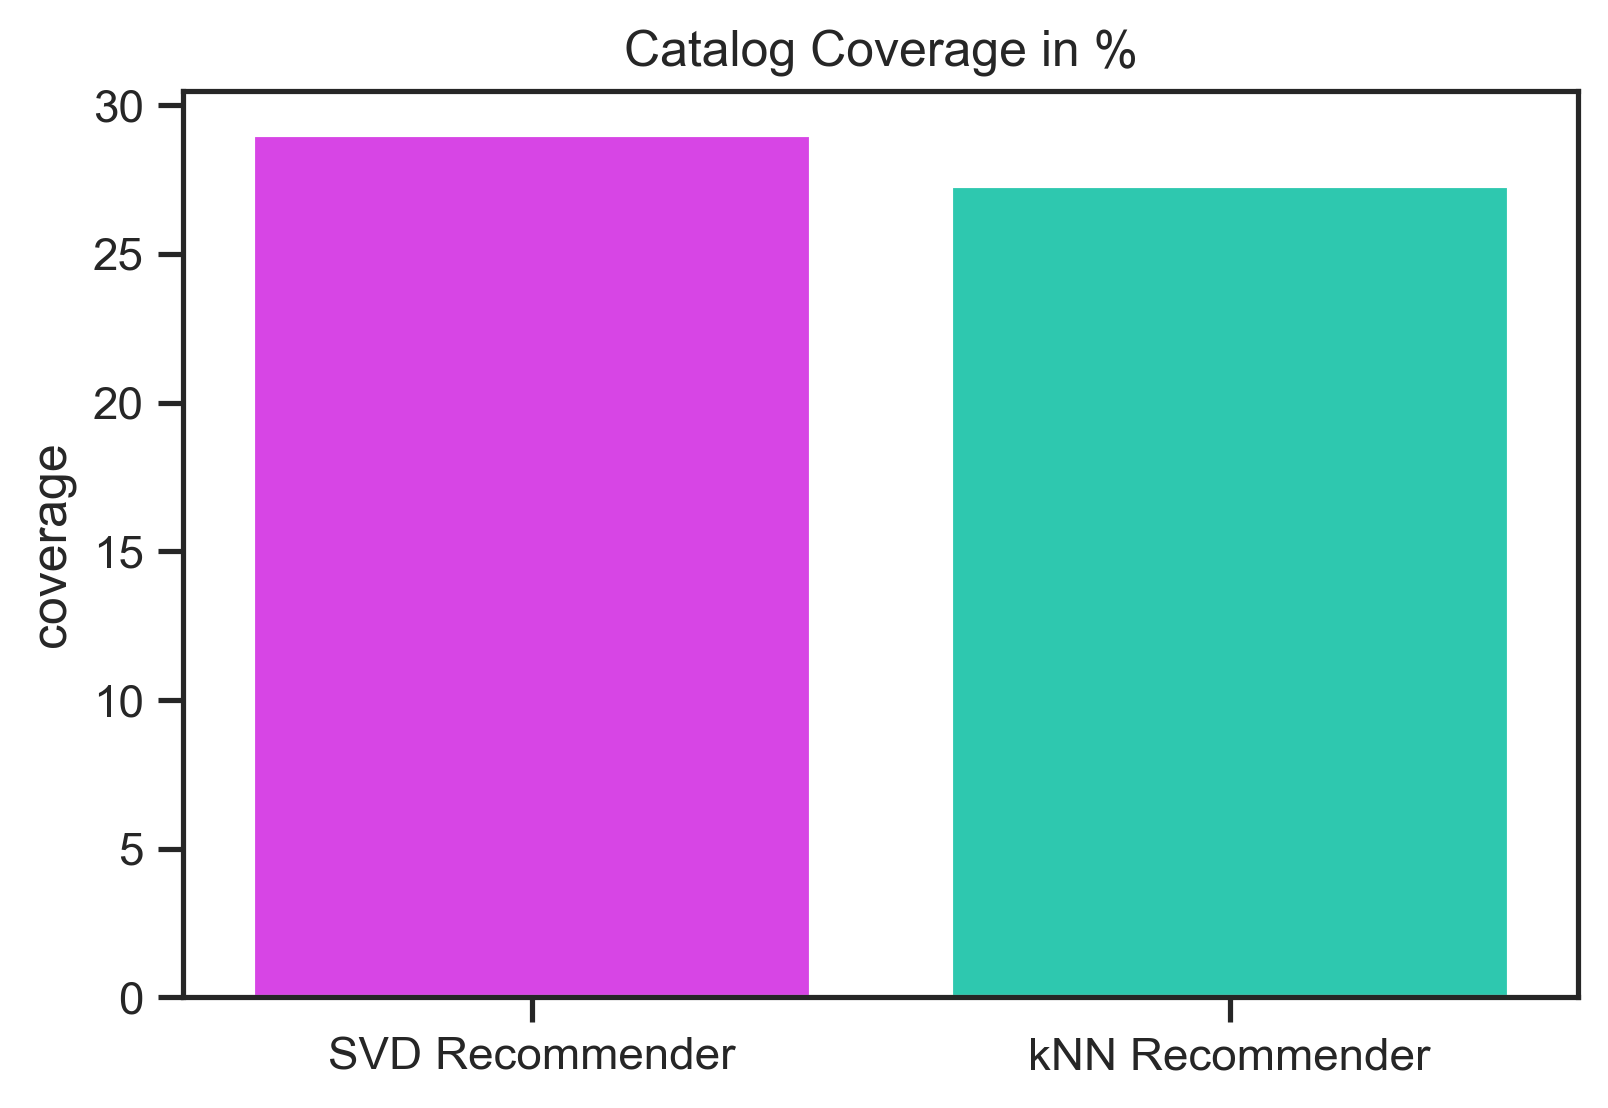

In [11]:
# plot of prediction coverage
coverage_scores = [svd_cat_coverage, knn_cat_coverage]
model_names = ['SVD Recommender', 'kNN Recommender']

recmetrics.coverage_plot(coverage_scores, model_names)

### Novelty

In [12]:
pop = dict(ratings.movieId.value_counts())

users = ratings["userId"].value_counts().index.tolist()

In [13]:
# top_novelty,top_mselfinfo_list = recmetrics.novelty(top_recs, pop, len(users), 10)
svd_novelty,svd_mselfinfo_list = recmetrics.novelty(svd_recs, pop, len(users), 10)
knn_novelty,knn_mselfinfo_list = recmetrics.novelty(knn_recs, pop, len(users), 10)

In [14]:
svd_novelty, knn_novelty

(3.7858659907215366, 3.823969733651874)